In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np

import os
import pickle
import tqdm
import time
import torch

from scipy.spatial.transform import Rotation as R

In [2]:
variant = 'llvm_ad_rgb'

In [3]:
mi.set_variant(variant)

### Hyper-parameters

These parameters were set for the woven patterns shared by Cem Yuksel

In [4]:
max_depth = 2 # Max Depth For Path Tracer (2 for single yarn, 4 for cloth sample)
rad = 2. # Yarn Radius
sigma = 5.5 # Sigma For Attenuation of Specular Y
sigma_d = 0.1 # Sigma For Attenuation of Specular Y # Basket
sigma_d = 0.125 # Sigma For Attenuation of Specular Y # Satin
tt_weight = 1.1 # Sampling Weight For Specular Y vs Diffuse Y (Set to 1.1 to ensure only Specular Y is sampled)
scale_V = 20 # V varies from 0 to 1 so change it to 0 to scale

'''Ply Parameters'''
# Plies are always assumed to be uniformly distributed
res = 1000 # Size of 1D Textures
num_ply = 2
ply_rad = 1.
ply_origin = ply_rad / np.sin(np.pi*2/(num_ply*2))
ply_twist = 1/3

'''Fiber Parameters'''
# These parameters are for generating a uniform fiber-cross section
res = 1000 # Size of 1D Textures
num_fibers = 40
fiber_rad = 1 / np.sqrt(50)
fiber_twist = -1.5
fiber_origin = fiber_rad / np.sin(np.pi*2/(num_fibers*2))

# Basket and Satin
shadow_thr = 0.5 # Adjust AO to make it between n to 1 instead of 0 to 1
ply_shadow_thr = 0.6 # Adjust AO to make it between n to 1 instead of 0 to 1


'''BSDF Parameters'''
m_eta = 1.5 # Refractive Index of Cloth Sample
m_r = 0.5 # Ratio between Body X and Body Y

# Satin
specx_alphau = 0.2
specx_alphav = 0.3

# Satin
specx_color = np.array([1., 1., 1.])

# Same For All
specy_alphau = 0.9
specy_alphav = 0.9
specy_color = [0.1, 0.1, 0.1]


diff_color_x = np.array([0.045, 0.015, 0.00])
diff_color_y = np.array([0.045, 0.015, 0.00])

print(ply_origin, ply_rad)
print(fiber_origin)

1.0 1.0
1.8024851666384858


In [5]:
def fixed_quat_to_matrix(q):
    q = q * dr.sqrt_two

    xx = q.x * q.x; yy = q.y * q.y; zz = q.z * q.z
    xy = q.x * q.y; xz = q.x * q.z; yz = q.y * q.z
    xw = q.x * q.w; yw = q.y * q.w; zw = q.z * q.w

    return mi.Matrix3f(
        1.0 - (yy + zz), xy - zw, xz + yw,
        xy + zw, 1.0 - (xx + zz), yz - xw,
        xz - yw,  yz + xw, 1.0 - (xx + yy)
    )

In [6]:
from RMF import *

### Cross-Section

In [7]:
class CrossSectionFiberDist:
    def __init__(self, fiber_dist_beta, fiber_dist_eps):
        self.fiber_dist_beta = fiber_dist_beta
        self.fiber_dist_eps = fiber_dist_eps
        
    def sampleR(self):
        while True:
            rand = np.random.rand(); 
            radius = np.sqrt(rand); pdf = rand
            if ( pdf < self.fiberDistribution(radius)):
                return radius
            
    def sampleFiberLocation(self):
        r = 0
        theta = 0

        while (True):
            # Sampling the unit disk.
            u1 = np.random.rand()
            u2 = np.random.rand()
            r = np.sqrt(u1)
            theta = 2.0 * np.pi * u2

            # Rejection.
            ksi = np.random.rand()
            if ksi < 1:
                break

        return (r, theta)
    
    def fiberDistribution(self, R):
        eTerm = (np.exp(1) - np.power(np.exp(1), R)) / (np.exp(1) - 1)
        pR = (1 - 2 * self.fiber_dist_eps) * np.power(eTerm, self.fiber_dist_beta) + self.fiber_dist_eps
        return pR;

In [8]:
class CrossSection:
    def __init__(self, fiber_count, fiber_twist, fiber_dist_beta, fiber_dist_eps, fiber_radius, fiber_origin, ply_radius=1.1):
        self.ply_radius = ply_radius
        
        self.fiber_count = fiber_count
        self.fiber_twist = fiber_twist
        self.fiber_dist_beta = fiber_dist_beta
        self.fiber_dist_eps = fiber_dist_eps
        self.fiber_radius = fiber_radius
        self.fiber_origin = fiber_origin
        
        self.fiber_dist = CrossSectionFiberDist(self.fiber_dist_beta, self.fiber_dist_eps)
        
        self.fibCenterDict = {}
        
        self.fibers = []
        self.phase = {}
        
        self.visFibers = []
        self.visFibersU = []
        self.visFibersCenter = []
        self.visFibersPhase = []
        
        self.aoCS = []
        self.pertCS = []
        self.theta0CS = []
        self.fibUtoShadow = []
        
    def genFibers(self, random=False):
        seed = 0; counter = 0
        for i in tqdm.trange(self.fiber_count):
            if not random:
                '''Repeatitive Stripes'''
                rad = self.fiber_origin
                angle = 2 * np.pi * i / self.fiber_count

                p = (rad * np.sin(angle), rad * np.cos(angle))
            else:
                '''Random Fiber Pattern'''                    
                rad = self.fiber_origin - np.random.rand() * self.fiber_radius * 2
                angle = 2 * np.pi * i / self.fiber_count

                p = (rad * np.sin(angle), rad * np.cos(angle))
                
            self.fibers.append(p)
            self.phase[p] = angle
                
    def findLineCircleIntersection(self, cntr, point1, point2):
        cx, cy = cntr[0], cntr[1]
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        m = dy / dx
        
        infSlop = point2[0] == point1[0]
        if infSlop:
            A = 1.0; B = -2 * cntr[1]
            C = (point1[0] - cntr[0])**2 + cntr[1]**2 - self.fiber_radius**2
            # C = (cntr[0])**2 + cntr[1]**2 - self.fiber_radius**2
        else:
            A = 1.0 + m**2
            B = -2.0 * cntr[0] - 2 * m**2 * point1[0] + 2 * m * point1[1] - 2 * m * cntr[1]
            C = cntr[0]**2 + m**2 * point1[0]**2 + point1[1]**2 - 2 * m * point1[0] * point1[1]
            C += cntr[1]**2 + 2 * m * point1[0] * cntr[1] - 2 * cntr[1] * point1[1] - self.fiber_radius**2
            # B = -2.0 * cntr[0] - 2 * m * cntr[1]
            # C = cntr[0]**2 + cntr[1]**2 - self.fiber_radius**2
            
        det = B**2 - 4 * A * C
        if det < 0:
            a1 = None
            a2 = a1
            r = 0
            return r, (a1,a1), (a1,a1)
        elif det == 0:
            a1 = - B / (2 * A)
            a2 = a1
            r = 1
        else:
            a1 = (-B + np.sqrt(det)) /  (2 * A)
            a2 = (-B - np.sqrt(det)) /  (2 * A)
            r = 2
        
        if infSlop:
            h1 = point1[0], a1
            h2 = point2[0], a2
        else:
            h1 = a1, m * (a1 - point1[0]) + point1[1]
            h2 = a2, m * (a2 - point1[0]) + point1[1]
            
        return r, h1, h2
    
    def closestHit(self, rayOrg, hit1, hit2):
        vec1 = np.array(hit1) - np.array(rayOrg); t1 = np.linalg.norm(vec1)
        vec2 = np.array(hit2) - np.array(rayOrg); t2 = np.linalg.norm(vec2)
        
        if t1 < t2:
            return hit1, t1
        else:
            return hit2, t2
        
    def extractAO(self, res):
        rad = self.ply_radius
        for u in tqdm.trange(res):
            pnt1 = self.visFibers[u]
            
            cntr = 0
            rayNum = 1000
            for r in range(rayNum):
                angle = np.random.rand() * 2 * np.pi
                pnt2 = np.array([rad*np.cos(angle) + pnt1[0], rad*np.sin(angle) + pnt1[1]])
                
                for i in range(self.fiber_count):
                    root_no, hit1, hit2 = self.findLineCircleIntersection(self.fibers[i], pnt1, pnt2)
                    if root_no == 0:
                        continue
                
                    hit_pnt, t = self.closestHit(pnt1, hit1, hit2)
                    
                    if ( root_no and t > 0.001 ):
                        cntr += 1
                        break
                        
            ao = cntr / rayNum
            self.aoCS.append(ao)
            
        self.aoCS = np.array(self.aoCS)
        self.aoCS = (self.aoCS - np.min(self.aoCS)) / (np.max(self.aoCS) - np.min(self.aoCS))
        self.aoCS = 1 - self.aoCS
        
    def extractTangents(self, res):
        plyRadius = self.ply_radius
        
        for u in tqdm.trange(res):
            theta0 = self.visFibersPhase[u]
            self.theta0CS.append(theta0)
                         
    def extractNormals(self, res=10):
        for u in tqdm.trange(res):
            self.visFibers.append([])
            self.visFibersCenter.append([])
            self.visFibersPhase.append([])
            self.visFibersU.append([])
            self.pertCS.append([])
            
            theta = u * (2 * np.pi / res)
            plyRad = self.ply_radius
            
            # Ray origin and destination
            x = plyRad * np.cos(theta); y = plyRad * np.sin(theta)
            org = (x,y)
            cntr = (0,0)
            
            min_t = np.inf
            for i in range(self.fiber_count):
                ctr_fiber = self.fibers[i][0], self.fibers[i][1]
                root_no, hit1, hit2 = self.findLineCircleIntersection(ctr_fiber, org, cntr)
                if root_no == 0:
                    continue
                
                fiber_hit, t = self.closestHit(org, hit1, hit2)
                
                org2cntr = np.array(cntr) - np.array(org)
                org2cntr = org2cntr / np.linalg.norm(org2cntr)
                dx = org2cntr[0]; dy = org2cntr[1]
                
                if t < min_t:
                    min_t = t
                    first_fiber_hit = fiber_hit
                    first_fiber_hit_center = ctr_fiber
                    
                    # fiber normal in plane y = 0
                    fiber_normal_2d = fiber_hit - np.array(ctr_fiber)
                    fiber_normal = np.zeros(3);
                    fiber_normal[0] = fiber_normal_2d[0]
                    fiber_normal[2] = fiber_normal_2d[1]
                    fiber_normal = fiber_normal / np.linalg.norm(fiber_normal)
                                        
                    ply_normal_2d = np.array([x,y])
                    dot = np.dot(ply_normal_2d, fiber_normal_2d)
                    cross = np.cross(ply_normal_2d, fiber_normal_2d)
                    angle = np.arctan2(cross, dot)
                    if angle < 0:
                        angle += 2 * np.pi
                        
                    fiber_ref_normal_2d = np.array([0,1])
                    dot = np.dot(fiber_ref_normal_2d, fiber_normal_2d)
                    cross = np.cross(fiber_ref_normal_2d, fiber_normal_2d)
                    U = np.arctan2(cross, dot)
                    if U < 0:
                        U += 2 * np.pi

                    geo_normal = - np.array([dx, dy, 0]); geo_normal = geo_normal / np.linalg.norm(geo_normal)
                    geo_tangent = - np.array([-dy, dx, 0]); geo_tangent = geo_tangent / np.linalg.norm(geo_tangent)
                    geo_binormal = np.cross(geo_normal, geo_tangent)
                    
                    fiber_normal_local = np.zeros(3)
                    fiber_normal_local[0] = np.dot(fiber_normal, geo_binormal)
                    fiber_normal_local[1] = np.dot(fiber_normal, geo_tangent)
                    fiber_normal_local[2] = np.dot(fiber_normal, geo_normal)
                    fiber_normal_local = fiber_normal_local / np.linalg.norm(fiber_normal_local)                    
            
            self.visFibers[u] = first_fiber_hit
            self.visFibersCenter[u] = first_fiber_hit_center
            self.visFibersPhase[u] = self.phase[first_fiber_hit_center]
            self.visFibersU[u] = U
            self.pertCS[u] = angle

In [9]:
# plyCS = CrossSection(num_ply, ply_twist, 0.5, 0.5, ply_rad, ply_origin, rad+0.1)
# plyCS.genFibers(False)
# plyCS.extractNormals(res)
# plyCS.extractTangents(res)
# plyCS.extractAO(res)

In [10]:
# with open('./tmp/plyCS_2.pickle', 'wb') as f:
#     pickle.dump(plyCS, f)

In [11]:
with open('./tmp/plyCS.pickle', 'rb') as f:
    plyCS = pickle.load(f)

In [12]:
plyCS.fiber_origin

1.0392304845413265

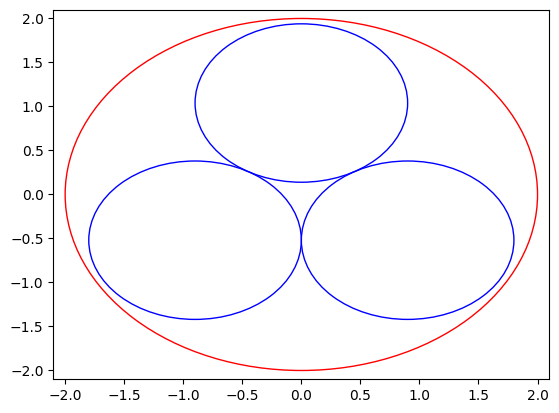

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
ax.set_xlim((-plyCS.ply_radius, plyCS.ply_radius))
ax.set_ylim((-plyCS.ply_radius, plyCS.ply_radius))
circle1 = plt.Circle((0, 0), plyCS.ply_radius-0.1, color='r', fill=False)
ax.add_patch(circle1)

for i in range(plyCS.fiber_count):
    circle = plt.Circle(plyCS.fibers[i], plyCS.fiber_radius, color='b', fill=False)
    ax.add_patch(circle)
    
plt.show()

In [14]:
# fibCS = CrossSection(num_fibers, fiber_twist, 0.5, 0.5, fiber_rad, fiber_origin, plyCS.fiber_radius+0.1)
# fibCS.genFibers(random=True)
# fibCS.extractNormals(res)
# fibCS.extractTangents(res)
# fibCS.extractAO(res)

In [15]:
# with open('./tmp/fibCS_random_single.pickle', 'wb') as f:
#     pickle.dump(fibCS, f)

In [16]:
with open('./tmp/fibCS_random.pickle', 'rb') as f:
    fibCS = pickle.load(f)
    
# fibCS.fiber_twist = -1.5

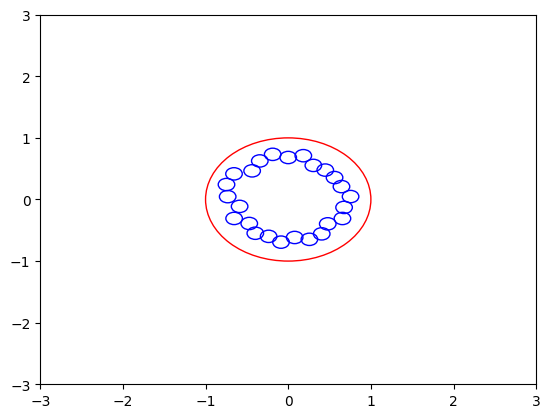

In [17]:
fig, ax = plt.subplots() 
ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
circle1 = plt.Circle((0, 0), fibCS.ply_radius, color='r', fill=False)
ax.add_patch(circle1)

for i in range(fibCS.fiber_count):
    circle = plt.Circle(fibCS.fibers[i], fibCS.fiber_radius, color='b', fill=False)
    ax.add_patch(circle)
        
plt.show()

### Diffuse X

In [18]:
class DiffuseX(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        # Read 'reflectance' properties from `props`
        self.diff_color = props['diff_x']
        
        self.eta = 1.5
        
        # For sub-surface assumption
        self.diff_to_reduced_albedo = [0.000100004, 0.469488, 0.690852, 0.815799, 0.889138, 0.93232,
                                       0.958012, 0.973687, 0.983534, 0.989866, 0.993985, 0.996656,
                                       0.998344, 0.999345, 0.999853, 0.9999,   1.0]
        
        alpha = [0,0,0]
        for i in range(3):
            f = self.diff_color[i] * 15.99
            j = int(f) & 15
            w = f - j
            alpha[i] = self.diff_to_reduced_albedo[j] * ( 1.0 - w ) + self.diff_to_reduced_albedo[j+1] * w
        
        self.alpha = mi.load_string('''<spectrum version='3.0.0' type='srgb' name="reflectance">
                                <rgb name="color" value="{}, {}, {}"/>
                             </spectrum>'''.format(alpha[0], alpha[1], alpha[2]))
        
        self.diff_color = mi.Color3f(props['diff_y'])
        self.diff_color_orig = mi.load_string('''<spectrum version='3.0.0' type='srgb' name="reflectance">
                                <rgb name="color" value="{}, {}, {}"/>
                             </spectrum>'''.format(props['diff_y'][0],props['diff_y'][1],props['diff_y'][2]))
        
        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.Smooth
        transmission_flags   = mi.BSDFFlags.DiffuseTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.Smooth
        
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags
    
    def sample(self, ctx, si, sample1, sample2, active):
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        bs = mi.BSDFSample3f()

        active &= cos_theta_i > 0

        bs.wo = mi.warp.square_to_cosine_hemisphere(sample2)
        bs.pdf = mi.warp.square_to_cosine_hemisphere_pdf(bs.wo)

        bs.sampled_type = mi.BSDFFlags.DiffuseReflection
        bs.sampled_component = 0

        value = self.diff_color

        return bs, value
        
    def eval_pdf(self, ctx, si, wo, active):
        mi.set_variant(variant)
        
        thresh = 1.
               
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        cos_theta_o = mi.Frame3f.cos_theta(wo)
        
        reflect = cos_theta_i * cos_theta_o > 0
        
        eta = dr.select(cos_theta_i > 0, self.eta, 1 / self.eta)
        inv_eta = dr.select(cos_theta_i > 0, 1 / self.eta, self.eta)
        
        alpha = self.alpha

        # Diffuse X
        Fdr = -1.440 / ( self.eta * self.eta ) + 0.710 / self.eta + 0.668 + 0.0636 * self.eta
        Fdr = dr.clip(Fdr, 0, 1)
        A = ( 1 + Fdr ) / ( 1 - Fdr )
        
        t1 = alpha.eval(si, active) / (4 * dr.pi * (cos_theta_o + cos_theta_i))
        str_ = dr.sqrt(3 * (1 - alpha.eval(si, active)))
        t2 = (alpha.eval(si, active) * 0.5) * (1 + dr.exp(-4 / 3 * A * str_)) * dr.exp(-str_) * (dr.inv_pi)
        
        value_xrb = mi.Color3f(t1)
        value_xrb_diff = mi.Color3f(t2)
        
        weight = (cos_theta_o + cos_theta_i) * dr.sign(cos_theta_o + cos_theta_i)
        weight = (weight - dr.min(weight)) / (dr.max(weight) - dr.min(weight))

        value_bx = dr.lerp(mi.Color3f(value_xrb_diff), mi.Color3f(value_xrb), weight)
        # value_bx = (mi.Color3f(value_xrb_diff) * (1 - thresh) + thresh * mi.Color3f(value_xrb))
                    
        # Diffuse Y
        value_by = mi.Color3f(self.diff_color_orig.eval(si, active) * 1 / dr.pi * dr.abs(cos_theta_o))        
        
        value = dr.select(reflect, value_bx, value_by)
        
        pdf = mi.warp.square_to_cosine_hemisphere_pdf(wo)

        return dr.abs(value), pdf

    def traverse(self, callback):
        callback.put_parameter('reflectance', self.reflectance, mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        print("🏝️ there is nothing to do here 🏝️")

    def to_string(self):
        return ('Diffuse[\n'
                '    diff_color=%s,\n'
                ']' % (self.diff_color))

In [19]:
mi.register_bsdf("diffuseX", lambda props: DiffuseX(props))

### Initialize All BSDFs

In [20]:
specX = mi.load_dict({
    'type' : 'roughdielectric',
    'alpha_u': specx_alphau,
    'alpha_v': specx_alphav,
    'distribution': 'ggx',
    'int_ior' : m_eta,        
    'ext_ior' : 1.,
    'specular_reflectance': {
        'type': 'rgb',
        'value': specx_color,
    },
    'specular_transmittance': {
        'type': 'rgb',
        'value': specx_color,
    },
})

In [21]:
specY = mi.load_dict({
    'type' : 'roughdielectric',
    'alpha_u': specy_alphau,
    'alpha_v': specy_alphav,
    'distribution': 'ggx',
    'int_ior' : 1.5,        
    'ext_ior' : 1.,
    'specular_reflectance': {
        'type': 'rgb',
        'value': [0.0, 0.0, 0.0],
    },
    'specular_transmittance': {
        'type': 'rgb',
        'value': specy_color,
    },
})

In [22]:
diffx = mi.load_dict({
    'type': 'diffuseX',
    'diff_x': diff_color_x,
    'diff_y': diff_color_y,
})

diffx

Diffuse[
    diff_color=[[0.04500000178813934, 0.014999999664723873, 0.0]],
]

In [23]:
diff_orig = mi.load_dict({
    'type': 'diffuse',
    'reflectance': {
        'type': 'rgb',
        'value': diff_color_x
    }
})

diff_orig

SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [[0.045, 0.015, 0]]
  ]
]

### Ply Intersection Code

In [24]:
def ray_test_ply(si, rmf_normal, plyCS, rays):
    mask = False
    
    final_t = dr.inf
    
    '''Use RMF To Create Frame'''    
    yarn_point = (si.p - rad * si.n)
    yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
    
    '''Projected Ray In 2D Cross-Section'''
    rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
    rays_projected_d = dr.normalize(rays_projected_d)
    rays_projected_o = si.p

    rays_projected = mi.Ray3f(rays_projected_o, rays_projected_d)
    
    length_yarn = si.uv.y
    
    rotation = mi.Transform4f.rotate(mi.Vector3f(0,0,1), 
                                (si.uv.y * -plyCS.fiber_twist) * 180 / dr.pi)
            
    for i in range(plyCS.fiber_count):
        '''Rotate To Get Center Location On Circular Cross-Section'''
        center = mi.Point3f(plyCS.fibers[i][0], plyCS.fibers[i][1], 0)
        
        new_center = rotation.transform_affine(center)
        
        frame_correction = mi.Transform4f.translate(yarn_point) @ mi.Transform4f.to_frame(yarn_frame)
        new_center = frame_correction.transform_affine(new_center)
                
        t = rayPlyIntersection2D_emmiter(new_center, rays_projected)
        final_t = dr.select(dr.abs(t) < dr.abs(final_t), t, final_t)

        dist_ray = (new_center-rays_projected_o) - \
                        dr.dot((new_center-rays_projected_o), rays_projected_d) * rays_projected_d
        
        mask = dr.or_(dr.norm(dist_ray) <= plyCS.fiber_radius, mask)
        
    # mask = ~dr.isinf(final_t)
    
    return mask

In [25]:
def rayPlyIntersection2D_emmiter(center, rays):
    a = dr.norm(rays.d)**2
    b = 2 * dr.dot(rays.o - center, rays.d)
    c = dr.norm(rays.o - center)**2 - plyCS.fiber_radius**2

    t1 = dr.select(b**2 - 4*a*c >=0, (-b + dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    t2 = dr.select(b**2 - 4*a*c >=0, (-b - dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    # t1 = dr.select(t1 > 0, t1, dr.inf); t2 = dr.select(t2 > 0, t2, dr.inf)
    
    t = dr.select(dr.abs(t1) < dr.abs(t2), t1, t2)
    
    return t

In [26]:
def rayPlyIntersection2D(center, rays):
    a = dr.norm(rays.d)**2
    b = 2 * dr.dot(rays.o - center, rays.d)
    c = dr.norm(rays.o - center)**2 - plyCS.fiber_radius**2

    t1 = dr.select(b**2 - 4*a*c >=0, (-b + dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    t2 = dr.select(b**2 - 4*a*c >=0, (-b - dr.sqrt(b**2 - 4*a*c)) / (2 * a), dr.inf)
    # t1 = dr.select(t1 > 0, t1, dr.inf); t2 = dr.select(t2 > 0, t2, dr.inf)
    
    t = dr.select(dr.abs(t1) < dr.abs(t2), t1, t2)
    
    return t

In [27]:
def updateCrossSection(si, hit_point, rmf_normal, plyCS, rays, additional_V=None):
    final_t = dr.inf
    dist = dr.inf
    ply_normal = mi.Vector3f(0)
    ply_binormal = mi.Vector3f(0)
    ply_tangent = mi.Vector3f(0)
    ply_hit_point = mi.Point3f(0)
    ply_center = mi.Point3f(0)
    ply_num = 0
    ply_count = mi.Float(0)
    final_yarn_point = mi.Point3f(0)
    
    # hit_point = hit_point + additional_V
    
    '''Use RMF To Create Frame'''    
    yarn_point = (hit_point - rad * si.n)
    yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
    
    # yarn_frame = mi.Frame3f(rmf_normal, dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), si.sh_frame.t)
    # yarn_frame = mi.Frame3f(si.sh_frame.t)
    
    '''Projected Ray In 2D Cross-Section'''
    rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
    rays_projected_d = dr.normalize(rays_projected_d)
    rays_projected_o = hit_point; 

    rays_projected = mi.Ray3f(rays_projected_o, rays_projected_d)
    
    length_yarn = hit_point.z #+ additional_V
    # length_yarn = si.uv.y #+ additional_V
    
    additional_V_vector = mi.Float(0)
    
    angle = np.linspace(0, np.pi * 2, plyCS.fiber_count, endpoint=False)
            
    for i in range(0,plyCS.fiber_count,1):
        hit_point = mi.Point3f(hit_point); hit_point = hit_point + si.sh_frame.t * mi.Float(additional_V[i])
        yarn_point = (hit_point - rad * si.n)
        length_yarn = mi.Float(additional_V[i])
        
        rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
        rays_projected_d = dr.normalize(rays_projected_d)
        rays_projected_o = hit_point; 

        rays_projected = mi.Ray3f(rays_projected_o, rays_projected_d)
        
        rotation = mi.Transform4f.rotate(mi.Vector3f(0,0,1), 
                                (length_yarn * -plyCS.fiber_twist) * 180 / dr.pi)
    
        '''Rotate To Get Center Location On Circular Cross-Section'''
        center = mi.Point3f(plyCS.fibers[i][0], plyCS.fibers[i][1], 0)
        
        new_center = rotation.transform_affine(center)
        
        frame_correction = mi.Transform4f.translate(yarn_point) @ mi.Transform4f.to_frame(yarn_frame)
        new_center = frame_correction.transform_affine(new_center)
        # new_center = dr.normalize(new_center) * mi.Float(plyCS.fiber_origin)
                
        '''Intersect Projected Rays With Plies In 2D'''
        t = rayPlyIntersection2D(new_center, rays_projected)
        
        '''Get Ply Tangent Using Helix Derivative'''
        x = mi.Float(dr.cos(length_yarn * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                        mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)
        y = -mi.Float(dr.sin(length_yarn * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                        mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)
        # x = mi.Float(dr.cos(length_yarn * mi.Float(plyCS.fiber_twist))) *\
        #                 mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)
        # y = -mi.Float(dr.sin(length_yarn * mi.Float(plyCS.fiber_twist))) *\
        #                 mi.Float(plyCS.fiber_origin) * mi.Float(plyCS.fiber_twist)

        v = mi.Vector3f(0); v.x = x; v.y = y; v.z = 1
        hel_tangent = dr.normalize(v)

        tangent_correction = mi.Transform4f.to_frame(yarn_frame)
        hel_tangent = dr.normalize(tangent_correction.transform_affine(hel_tangent))
        
        '''Update Hit-Point Normals And Tangents'''
        t_mask = dr.abs(t) < dr.abs(final_t)
        ply_hit_point = dr.select(t_mask, rays_projected_o + t * rays_projected_d, ply_hit_point)
        ply_normal = dr.select(t_mask, dr.normalize(ply_hit_point - new_center), ply_normal)
        ply_binormal = dr.select(t_mask, dr.normalize(si.sh_frame.s - dr.dot(ply_normal, si.sh_frame.s) * ply_normal), ply_binormal)
        ply_tangent = dr.select(t_mask, hel_tangent, ply_tangent)
        # ply_tangent = dr.select(t_mask, dr.normalize(dr.cross(ply_normal, ply_binormal))*-1, ply_tangent)
        ply_center = dr.select(t_mask, new_center, ply_center)
        ply_num = dr.select(t_mask, i, ply_num)
        
        additional_V_vector = dr.select(t_mask, additional_V[i], additional_V_vector)
        
        final_yarn_point = dr.select(t_mask, hit_point, final_yarn_point)
        
        final_t = dr.select(dr.abs(t) < dr.abs(final_t), t, final_t)
    
        ply_count += dr.select(dr.isinf(t), 0., 1.)
        
    return final_t, ply_normal, ply_tangent, ply_count, ply_center, ply_hit_point, final_yarn_point, additional_V_vector

In [28]:
def rayPlyIntersection3D(si, active, rmf_normal, plyCS, rays):
    mask = False
    not_mask = False
    
    final_t = mi.Mask(False)
    
    rays_projected_d = rays.d - dr.dot(rays.d, si.sh_frame.t) * si.sh_frame.t
    rays_projected_d = dr.normalize(rays_projected_d)
    rays_projected_o = si.p
    
    theta = dr.atan2(dr.norm(dr.cross(rays_projected_d, rays.d)), dr.dot(rays_projected_d, rays.d)) 
    theta += dr.select(theta < 0, dr.two_pi, 0)
    
    rotation_transform_normal = mi.Transform4f.translate(mi.Point3f(si.p)) \
                                    @ mi.Transform4f.rotate(mi.Vector3f(si.sh_frame.s), -theta * 180 / dr.pi) \
                                    @ mi.Transform4f.translate(-mi.Point3f(si.p)) 
    # rotation_transform_normal = mi.Transform4f.rotate(mi.Vector3f(si.sh_frame.s), -theta * 180 / dr.pi) 
    major_axis_dir = dr.normalize(rotation_transform_normal @ mi.Vector3f(si.n))
    
    # rotation_transform_binormal = mi.Transform4f.translate(mi.Point3f(si.p)) \
    #                                 @ mi.Transform4f.rotate(mi.Vector3f(si.sh_frame.n), -theta) \
    #                                 @ mi.Transform4f.translate(-mi.Point3f(si.p)) 
    # minor_axis_dir = dr.normalize(rotation_transform_binormal @ mi.Vector3f(si.sh_frame.s))
    minor_axis_dir = mi.Vector3f(si.sh_frame.s)
    
    plane_point = si.p
    rotation_transform_normal = mi.Transform4f.rotate(mi.Vector3f(si.sh_frame.s), -theta * 180 / dr.pi)
    plane_normal = dr.normalize(rotation_transform_normal.transform_affine(mi.Vector3f(si.sh_frame.t)))
    # plane_normal = dr.normalize(dr.cross(minor_axis_dir, major_axis_dir))
    
    rays_extended = mi.Ray3f(rays)
    # rays_extended.o = si.p - 1.0e-3 * si.n
    rays_extended.o = si.p - 1.0e-3 * si.n
    
    rays_extended.d = dr.normalize(major_axis_dir)
    back_hit = scene.ray_intersect(rays_extended, active)
    back_hit_point = mi.Point3f(back_hit.p)
        
    iterations = iters
    
    t_plies = []
    
    for i in range(0,plyCS.fiber_count,1):
        # rotation = mi.Transform4f.rotate(mi.Vector3f(0,0,1), 
        #                         (si.p.z * -plyCS.fiber_twist) * 180 / dr.pi)
    
        '''Rotate To Get Center Location On Circular Cross-Section'''
        center = mi.Point3f(plyCS.fibers[i][0], plyCS.fibers[i][1], 0)
        phase = dr.two_pi / plyCS.fiber_count * i
        origin = plyCS.fiber_origin
        
        t = mi.Float(si.uv.y)
        
        hit_point = mi.Point3f(si.p)
        
        # center = rotation.transform_affine(center)
        
        for it in range(iterations):
            x_t = mi.Float(dr.sin(t * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                        mi.Float(plyCS.fiber_origin)
            y_t = mi.Float(dr.cos(t * mi.Float(plyCS.fiber_twist) + dr.two_pi/plyCS.fiber_count*i)) *\
                            mi.Float(plyCS.fiber_origin)
            z_t = mi.Float(0)
            
            yarn_point = (hit_point - rad * si.n)
            yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
            
            frame_correction = mi.Transform4f.translate(yarn_point) @ mi.Transform4f.to_frame(yarn_frame)
            ply_center = frame_correction.transform_affine(mi.Point3f(x_t, y_t, z_t))
                    
            t_line = (dr.dot(si.p, plane_normal) - dr.dot(ply_center, plane_normal)) / dr.dot(si.sh_frame.t, plane_normal)
                                    
            t = t + t_line
            hit_point = hit_point + t_line * si.sh_frame.t
            
        t_plies.append(mi.Float(t))
    
    # hit_point = mi.Point3f(si.p)
    # hit_point.z = mi.Float(t)
    
    t_ply, ply_normal, ply_tangent, ply_count, ply_center, ply_hit_point, hit_point, add_V = updateCrossSection(si, si.p,
                                                                                                             rmf_normal,
                                                                                                             plyCS,
                                                                                                             rays,
                                                                                                             t_plies) 
    final_t = ~dr.isinf(t_ply)
    
    length_yarn = mi.Float(add_V)
    
    '''Use RMF To Create Frame'''    
    yarn_point = (hit_point - rad * si.n)
    yarn_frame = mi.Frame3f(dr.normalize(dr.cross(si.sh_frame.t,rmf_normal)*-1), rmf_normal, si.sh_frame.t)
    
    '''Remove Component Of Normal Along Tanget'''
    ply_normal = dr.normalize(ply_normal-dr.dot(ply_normal, ply_tangent)*ply_tangent)
    
    '''Ply UV Calculation'''
    ply_reference_normal = dr.normalize(rmf_normal-dr.dot(rmf_normal, ply_tangent)*ply_tangent)
    ply_reference_binormal = dr.normalize(dr.cross(ply_reference_normal, ply_tangent))
    
    ply_uv = dr.atan2(dr.dot(ply_normal, ply_reference_normal), dr.dot(ply_normal, ply_reference_binormal))
    ply_uv += dr.select(ply_uv < 0, dr.two_pi, 0) # + ply_num * np.random.rand()*dr.pi
    
    '''Ply-Hit Mask'''
    mask = mi.Mask(final_t)
    
    '''Ply Reference Frame For Fiber Mapping'''
    ply_reference_frame = mi.Frame3f(ply_reference_binormal, ply_reference_normal, ply_tangent)
    
    '''Get Ply Shadow'''
    ply_hit_yarn_normal = dr.normalize(ply_hit_point-yarn_point)
    angle = dr.atan2(dr.dot(ply_hit_yarn_normal, yarn_frame.t), dr.dot(ply_hit_yarn_normal, yarn_frame.s))
    angle += dr.select(angle<0, dr.two_pi, 0)
    
    u = mi.Float(angle)
    u += plyCS.fiber_twist * length_yarn
    u -= dr.trunc(u / dr.two_pi) * dr.two_pi
    u /= dr.two_pi
    u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
    u = mi.Point1i(u).x
    u = dr.select(u < 0, 1000+u,u)
    
    aoCS = dr.llvm.ad.Float(np.array(plyCS.aoCS))
    ply_shadow = dr.gather(dtype=type(aoCS), source=aoCS, index=u, active=si.is_valid())
    
    del aoCS
        
    return mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv / dr.two_pi, ply_count, hit_point, t

### Fiber Intersection Code

In [29]:
def updateFiberGeometry(si, cs, uv, ply_reference_frame, res=1000, h=mi.Point3f(0), d_factor = 20., num_samples=100):
    h_max_to_u = mi.Float(dr.asin(h.z / cs.ply_radius))
    h_min_to_u = mi.Float(dr.asin(h.y / cs.ply_radius))
    h = (h_max_to_u - h_min_to_u) / num_samples
    # h_to_u = mi.Float(dr.asin(h))
    
    '''Get The T-value = length of curve till that point'''    
    t_hel = si.uv.y # Length using V-value of each cylinder
    t_world = t_hel
    
    ply_uv = mi.Point2f(uv, dr.sqrt((plyCS.fiber_origin * plyCS.fiber_twist)**2 + 1) * (t_world))
    # ply_uv = si.uv
    
    final_fiber_normal = mi.Vector3f(0)
    final_fiber_tangent = mi.Vector3f(0)
    final_fiber_shadow = mi.Float(0)
    weight_sum = mi.Float(0)
    
    u = mi.Point2f(ply_uv).x * dr.two_pi
    u += cs.fiber_twist * ply_uv.y
    u -= dr.trunc(u / dr.two_pi) * dr.two_pi
    u /= dr.two_pi
    u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
    u = mi.Point1i(u).x
    u = dr.select(u < 0, 1000+u,u)
    
    # fib_center = dr.llvm.ad.Array2f(np.array(cs.visFibersCenter))
    # curr_fiber_center = dr.gather(dtype=type(fib_center), source=fib_center, index=u, active=si.is_valid())
    # del fib_center
    
    fib_hit = dr.llvm.ad.Array2f(np.array(cs.visFibers))
    curr_fiber_hit = dr.gather(dtype=type(fib_hit), source=fib_hit, index=u, active=si.is_valid())
    del fib_hit
    
    for i in range(num_samples):
    # for i in range(0, num_samples, 1):
        u = mi.Point2f(ply_uv).x * dr.two_pi + (i * (h) + h_min_to_u)
        u += cs.fiber_twist * ply_uv.y # + (dr.sqr(h_to_u) - dr.sqr(h_to_u * i / num_samples))
        u -= dr.trunc(u / dr.two_pi) * dr.two_pi
        u /= dr.two_pi
        u = u * (res-1); u = dr.select(dr.isnan(u), 0, u)
        u = mi.Point1i(u).x
        u = dr.select(u < 0, 1000+u,u)

        '''Fiber Normal Rotation Angle based on UV'''
        pertCS = dr.llvm.ad.Float(np.array(cs.pertCS))
        fib_normal_pert_angle = dr.gather(dtype=type(pertCS), source=pertCS, index=u, active=si.is_valid())    

        '''Fiber Tangent Phase based on UV'''
        theta0CS = dr.llvm.ad.Float(np.array(cs.theta0CS))
        theta0 = dr.gather(dtype=type(theta0CS), source=theta0CS, index=u, active=si.is_valid())

        fib_center = dr.llvm.ad.Array2f(np.array(cs.visFibersCenter))
        fiber_origin = dr.gather(dtype=type(fib_center), source=fib_center, index=u, active=si.is_valid())
        fiber_origin = dr.norm(fiber_origin)
        
        # weight = dr.exp(-d_factor * dr.norm(fiber_center-curr_fiber_center))

        fib_hit = dr.llvm.ad.Array2f(np.array(cs.visFibers))
        fiber_hit = dr.gather(dtype=type(fib_hit), source=fib_hit, index=u, active=si.is_valid())
        
        # fiber_hit_3d = mi.Point3f(fiber_hit.x, fiber_hit.y, 0)
        # frame_correction = mi.Transform4f.translate(si.p-(cs.ply_radius-0.1)*si.n) @ mi.Transform4f.to_frame(ply_reference_frame)
        # new_fib_hit = frame_correction.transform_affine(fiber_hit_3d)
        
        weight = dr.exp(-d_factor * dr.norm(fiber_hit-curr_fiber_hit))

        '''Ambient Occlusion based on UV'''
        aoCS = dr.llvm.ad.Float(np.array(cs.aoCS))
        fib_shadow_x = dr.gather(dtype=type(aoCS), source=aoCS, index=u, active=si.is_valid())

        '''Get the Fiber Tangent and transform to match the axis of the ply'''
        # start = time.time()
        x = mi.Float(dr.cos(ply_uv.y * mi.Float(cs.fiber_twist) + theta0)) * fiber_origin * mi.Float(cs.fiber_twist) #* 2.3
        y = mi.Float(-dr.sin(ply_uv.y * mi.Float(cs.fiber_twist) + theta0)) * fiber_origin * mi.Float(cs.fiber_twist) #* 2.3
        # print('x',time.time()-start)

        # start = time.time()
        v = mi.Vector3f(0); v.x = x; v.y = y; v.z = 1
        hel_tangent = dr.normalize(v)
        # print('t',time.time()-start)

        duv = si.sh_frame.t
        length = dr.norm(duv)

        to_world = mi.Transform4f.to_frame(ply_reference_frame)
        hel_tangent = dr.normalize(to_world.transform_affine(hel_tangent))
        # hel_tangent = si.sh_frame.t

        '''Update Fiber Normal by removing component of Fiber Tangent Along It'''
        fib_normal = mi.Vector3f(si.n)
        fib_normal = dr.normalize(fib_normal - dr.dot(fib_normal, hel_tangent) * hel_tangent)

        axis = dr.normalize(hel_tangent)
        zn = dr.rotate(mi.Quaternion4f, axis, fib_normal_pert_angle); zn = fixed_quat_to_matrix(zn)
        fib_normal = dr.normalize(zn @ fib_normal)
        
        final_fiber_normal += weight * fib_normal
        final_fiber_tangent += weight * hel_tangent
        # final_fiber_shadow += weight * fib_shadow_x
        final_fiber_shadow += fib_shadow_x
        weight_sum += weight

        del aoCS
        del theta0CS
        del fib_hit
        del fib_center
        del fib_normal_pert_angle
            
    # return dr.normalize((final_fiber_normal) / weight_sum), dr.normalize((final_fiber_tangent) / weight_sum), final_fiber_shadow / weight_sum
    return dr.normalize((final_fiber_normal) / weight_sum), dr.normalize((final_fiber_tangent) / weight_sum), final_fiber_shadow / num_samples

In [30]:
def mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, rays, h=mi.Point3f(0), num_samples=10):
    fiber_normal, fiber_tangent, fiber_shadow = updateFiberGeometry(si, fibCS, ply_uv, ply_reference_frame, 
                                                                    h=h, num_samples=num_samples)

    si.n = dr.select(bsdf_mask, dr.normalize(fiber_normal), si.n)
    si.sh_frame.n = si.n
    si.sh_frame.t = dr.select(bsdf_mask, dr.normalize(fiber_tangent), si.sh_frame.t)
    si.sh_frame.s = dr.select(bsdf_mask, dr.normalize(dr.cross(si.sh_frame.n, si.sh_frame.t)) * -1, si.sh_frame.s)
    
    return si, fiber_shadow

### Scene Intersection 

In [31]:
def intersectWithScene(scene, rays, active, plyCS, scale=60):
    si = scene.ray_intersect(rays, active)
    valid_ray = si.is_valid() & active
    
    rmf_normal = mi.Vector3f(si.n) # For now we store the RMF normal in si.n
    
    yarn_number = si.dn_du.x; si.dn_du.x = 0;
    
    per_yarn_length = dr.llvm.ad.Float(np.array(length_sum))
    scale_f = dr.gather(dtype=type(per_yarn_length), source=per_yarn_length, index=mi.Int(yarn_number), active=si.is_valid())
    
    uv = mi.Point2f(si.uv)
    si.uv.x = uv.y 
    si.uv.y = uv.x * scale_f # V in [0,1] so scale it to make the ply twist more visible
                
    frame = mi.Frame3f(si.sh_frame)
    si.sh_frame.t = frame.s
    si.sh_frame.s = frame.t
    si.n = si.sh_frame.n
    
    '''Generate No-Hit Mask And Get Ply Geometry'''
    # start = time.time()
    hit, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv, ply_count, hit_point, intersec = rayPlyIntersection3D(si, 
                                                                                                            active, 
                                                                                                            rmf_normal, 
                                                                                                            plyCS, rays)
    # print('Time for ply mapping', time.time()-start)
    
    bsdf_mask = dr.and_(valid_ray, hit)
    
    si.n = dr.select(bsdf_mask, dr.normalize(ply_normal), si.n)
    si.sh_frame.n = si.n
    si.sh_frame.t = dr.select(bsdf_mask, dr.normalize(ply_tangent), si.sh_frame.t)
    si.sh_frame.s = dr.select(bsdf_mask, dr.normalize(dr.cross(si.sh_frame.n, si.sh_frame.t)) * -1, si.sh_frame.s)
    
    # si.p = ply_hit_point
        
    return si, bsdf_mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, ply_uv, ply_count, hit_point, intersec

In [32]:
def ray_test(scene2, rays2, emitter_point, active2, scale2=60):
    # return prev_mask
    final_mask = mi.Mask(False)
    
    it = 0
    
    while it < 2:
        
        si2 = scene2.ray_intersect(rays2, active2)
        
        yarn_number = si2.dn_du.x; si2.dn_du.x = 0;
    
        per_yarn_length = dr.llvm.ad.Float(np.array(length_sum))
        scale_f = dr.gather(dtype=type(per_yarn_length), source=per_yarn_length, index=mi.Int(yarn_number), active=si2.is_valid())

        rmf_normal2 = mi.Vector3f(si2.n) # For now we store the RMF normal in si.n 

        uv = mi.Point2f(si2.uv)
        si2.uv.x = uv.y 
        si2.uv.y = uv.x * scale_f # V in [0,1] so scale it to make the ply twist more visible

        frame = mi.Frame3f(si2.sh_frame)
        si2.sh_frame.t = frame.s
        si2.sh_frame.s = frame.t
        si2.n = si2.sh_frame.n

        mask2 = ray_test_ply(si2, rmf_normal2, plyCS, rays2)
        
        rays2 = mi.Ray3f(si2.p+1.0e-6*(emitter_point-si2.p), dr.normalize(emitter_point-si2.p))
        active2 = si2.is_valid()
        
        final_mask = dr.or_(final_mask, mask2)
        
        it += 1
        
    return final_mask

### Custom Integrator

In [33]:
from common import *
from typing import *

In [34]:
def mis_weight(pdf_a, pdf_b):
    a2 = dr.sqr(pdf_a)
    b2 = dr.sqr(pdf_b)
    w = a2 / (a2 + b2)
    return dr.detach(dr.select(dr.isfinite(w), w, 0))

def integrator_sample(scene, sampler, rays, medium, active):
    mi.set_variant(variant)
    # rd = mi.Point3f(0); rd.z = rays.o.z * 2
    # rays.d = dr.normalize(rd - rays.o)
    # rays.d = mi.Vector3f(-1,0,0)
    
    rays.d = dr.normalize(rays.d)
    rays.d_x = dr.normalize(rays.d_x)
    rays.d_y = dr.normalize(rays.d_y)
        
    ctx = mi.BSDFContext()
    result = mi.Float(0.)
    depth = 0
    prev_si = mi.SurfaceInteraction3f()
    prev_mask = mi.Mask(False)
    throughput = mi.Spectrum(1.)
    prev_attn_fac = mi.Float(1.)
    prev_attn_d_fac = mi.Float(1.)
    F_prev = 1.
    
    while depth < max_depth:
        '''Ray Scene Intersection'''
        si, mask, ply_normal, ply_tangent, ply_shadow, ply_reference_frame, \
                    ply_uv, ply_count, ply_center, intersec = intersectWithScene(scene, rays, active, plyCS)
        ply_shadow = ply_shadow * (1 - ply_shadow_thr) + ply_shadow_thr
        ply_shadow = dr.select(dr.eq(plyCS.fiber_count, 1), 1., ply_shadow)
                
        active = si.is_valid()
        
        '''Calculate Azimuthal Offset'''
        if depth == 0:
            h_min = -dr.select(active, dr.norm((rays.o + si.t * rays.d) - (rays.o_x + si.t * rays.d_x)), 0)
            h_max = dr.select(active, dr.norm((rays.o + si.t * rays.d) - (rays.o_y + si.t * rays.d_y)), 0)
            
            h_range = np.array(dr.abs(dr.max(h_max) - dr.min(h_min)))[0]
            # h_range = dr.select(active, 
            
            print(dr.min(h_min))
            print(dr.max(h_max))
            print(h_range)
                          
        # print(dr.min(dr.select(active, h_min, dr.inf)), dr.min(dr.select(active, h_max, dr.inf)))
        # print(dr.max(dr.select(active, h_min, 0)), dr.max(dr.select(active, h_max, 0)))
        
        if depth == 0:
            prev_si = mi.SurfaceInteraction3f(si)
        
        if depth % 2 == 0:
            bsdf_mask = mi.Mask(mask)
                    
        '''Emitter Sampling'''
        emitter_vis = si.emitter(scene, active)
        
        sample_emitter = active
        
        sample_emitter = dr.and_(active, bsdf_mask)
        
        ds, emitter_val = scene.sample_emitter_direction(si, sampler.next_2d(sample_emitter), False, sample_emitter)
        
        emitter_ray = mi.Ray3f(si.p+1.0e-6*(ds.p-si.p), ds.d)
        occluded = ray_test(scene, emitter_ray, ds.p, sample_emitter)

        ds.pdf = dr.select(occluded, 0, ds.pdf)
        emitter_val = dr.select(occluded, 0, emitter_val)
        
        emitter_val = dr.select(dr.neq(ds.pdf, 0), emitter_val / ds.pdf, 0)
        active_e = sample_emitter & dr.neq(ds.pdf, 0.0)
        
        '''Geometry Mapping For Ply And Fiber'''        
        si, fiber_shadow = mapPlyFiberGeometry(si, ply_uv, ply_reference_frame, bsdf_mask, fibCS, 
                                               rays, h=mi.Point3f((dr.abs(h_max-h_min), h_min, h_max)), num_samples=25)
        
        fiber_shadow = fiber_shadow * (1 - shadow_thr) + shadow_thr

        
        '''Eval BSDF'''
        # si = mi.SurfaceInteraction3f(orig_si)

        si.wi = si.to_local(-rays.d)
        wo = si.to_local(ds.d) 
        
#         # Calculate B(wi, wo)
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        cos_theta_o = mi.Frame3f.cos_theta(wo)
        
        reflect = mi.Mask((cos_theta_i * cos_theta_o) > 0)
                
        F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
        
        Fx = dr.select(reflect, F_curr, F_prev)
        Fy = dr.select(reflect, F_prev, F_curr)
        
#         # Get r
        r = dr.select(reflect, m_r, (1 - m_r))
        
#         # Specular Component
        attn_fac = dr.select(depth % 2 == 0, 1, dr.power(dr.abs(dr.exp(-sigma * dr.norm(si.p-prev_si.p))), ply_count))
        attn_fac = dr.select(dr.isnan(attn_fac), 1, attn_fac)

        if depth % 2 == 0:
            # X-Component At First Hit
            cos_theta_i = mi.Frame3f.cos_theta(si.wi)

            F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
            
            specX = mi.load_dict({
                'type' : 'roughdielectric',
                'alpha_u': specx_alphau + h_range/(10),
                'alpha_v': specx_alphav + h_range/(10),
                'distribution': 'ggx',
                'int_ior' : m_eta,        
                'ext_ior' : 1.,
                'specular_reflectance': {
                    'type': 'rgb',
                    'value': specx_color,
                },
                'specular_transmittance': {
                    'type': 'rgb',
                    'value': specx_color,
                },
            })
            
            bsdf_val, bsdf_pdf = specX.eval_pdf(ctx, si, wo, bsdf_mask)
            bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val)
        else:
            # Y-Component At Second Hit
            cos_theta_i = mi.Frame3f.cos_theta(si.wi)

            F_curr = mi.fresnel(cos_theta_i, m_eta)[0]
            
            bsdf_val, bsdf_pdf = specY.eval_pdf(ctx, si, wo, bsdf_mask)
            bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val) # * attn_fac
            
        mis = dr.select(ds.delta, 1.0, mis_weight(ds.pdf, bsdf_pdf))
        
        result += dr.select(dr.and_(sample_emitter, bsdf_mask), 
                            prev_attn_fac * attn_fac * r * bsdf_val * emitter_val * mis, # * fiber_shadow 
                            mi.Color3f(0.0))
        
#         # Body Component
        attn_fac_d = dr.select(depth % 2 == 0, 1, dr.power(dr.abs(dr.exp(-sigma_d * dr.norm(si.p-prev_si.p))), ply_count))
        attn_fac_d = dr.select(dr.isnan(attn_fac_d), 1, attn_fac_d)
        
        bsdf_val, _ = diffx.eval_pdf(ctx, si, wo, bsdf_mask)
        _, bsdf_pdf = diff_orig.eval_pdf(ctx, si, wo, bsdf_mask)
        bsdf_val = dr.select(dr.isnan(bsdf_val), 0, bsdf_val)
                
        mis = dr.select(ds.delta, 1.0, mis_weight(ds.pdf, bsdf_pdf))
        
        result += dr.select(dr.and_(sample_emitter, bsdf_mask), 
                            prev_attn_d_fac * attn_fac_d * bsdf_val * r * ply_shadow * emitter_val * mis * fiber_shadow, #  , 
                            mi.Color3f(0.0))
        
        # result = dr.select(occluded, mi.Color3f(0), mi.Color3f(1))        
        
        '''Sample Ray Direction'''
        if depth % 2 == 0:            
            sx_sample, sx_weight = specX.sample(ctx, si,
                                                1.1,
                                                sampler.next_2d(),
                                                bsdf_mask)
            bsdf_sample = sx_sample
            bsdf_weight = sx_weight
        else:            
            sx_sample, sx_weight = specY.sample(ctx, si,
                                                1.1,
                                                sampler.next_2d(),
                                                bsdf_mask)
            bsdf_sample = sx_sample
            bsdf_weight = sx_weight
        
        origin = si.p + rays.d * 1.0e-3
        direction = dr.select(bsdf_mask, si.to_world(bsdf_sample.wo), 
                                                   rays.d)
        rays = mi.Ray3f(origin, dr.normalize(direction))
        
        prev_si = mi.SurfaceInteraction3f(si)
        prev_mask = dr.select(depth % 2 == 0, mi.Mask(bsdf_mask), prev_mask)
        prev_attn_fac *= dr.select(bsdf_mask, attn_fac, 1.)
        prev_attn_d_fac *= dr.select(bsdf_mask, attn_fac_d, 1.)
        
        throughput *= dr.select(bsdf_mask, bsdf_weight, mi.Spectrum(1))
        
        F_prev = mi.Float(F_curr)
        
        active = si.is_valid()
        
        depth += 1
               
    return result, bsdf_mask, dr.select(bsdf_mask, si.t, 0.0)

### Custom Integrator Ray Differential

In [35]:
class MyDirectIntegrator(mi.SamplingIntegrator):
    def __init__(self, props):
        mi.SamplingIntegrator.__init__(self, props)

    def sample(self, scene, sampler, ray, medium, active):
        mi.set_variant(variant)

        result, is_valid, depth = integrator_sample(scene, sampler, ray, medium, active)
        return result, is_valid, [depth]
    
    def render_forward(self: mi.SamplingIntegrator,
                       scene: mi.Scene,
                       params: Any,
                       sensor: Union[int, mi.Sensor] = 0,
                       seed: int = 0,
                       spp: int = 0) -> mi.TensorXf:
                
        if isinstance(sensor, int):
            sensor = scene.sensors()[sensor]

        film = sensor.film()
        aovs = self.aovs()

        # Disable derivatives in all of the following
        with dr.suspend_grad():
            # Prepare the film and sample generator for rendering
            sampler, spp = self.prepare(sensor, seed, spp, aovs)

            reparam = None
            
            # Generate a set of rays starting at the sensor, keep track of
            # derivatives wrt. sample positions ('pos') if there are any
            ray, weight, pos, det = self.sample_rays(scene, sensor,
                                                     sampler, reparam)

            with dr.resume_grad():
                L, valid, _ = self.sample(
                    scene=scene,
                    sampler=sampler,
                    ray=ray,
                    medium=None,
                    active=mi.Bool(True)
                )

                block = film.create_block()
                # Only use the coalescing feature when rendering enough samples
                block.set_coalesce(block.coalesce() and spp >= 4)

                # Deposit samples with gradient tracking for 'pos'.
                # After reparameterizing the camera ray, we need to evaluate
                #   Σ (fi Li det)
                #  ---------------
                #   Σ (fi det)
                ADIntegrator._splat_to_block(
                    block, film, pos,
                    value=L * weight * det,
                    weight=det,
                    alpha=dr.select(valid, mi.Float(1), mi.Float(0)),
                    wavelengths=ray.wavelengths
                )

                # Perform the weight division and return an image tensor
                film.put_block(block)
                result_img = film.develop()

                dr.forward_to(result_img)

        return dr.grad(result_img)
    
    def sample_rays(
        self,
        scene: mi.Scene,
        sensor: mi.Sensor,
        sampler: mi.Sampler,
        reparam: Callable[[mi.Ray3f, mi.UInt32, mi.Bool],
                          Tuple[mi.Vector3f, mi.Float]] = None
    ) -> Tuple[mi.RayDifferential3f, mi.Spectrum, mi.Vector2f, mi.Float]:

        film = sensor.film()
        film_size = film.crop_size()
        rfilter = film.rfilter()
        border_size = rfilter.border_size()

        if film.sample_border():
            film_size += 2 * border_size

        spp = sampler.sample_count()

        # Compute discrete sample position
        idx = dr.arange(mi.UInt32, dr.prod(film_size) * spp)

        # Try to avoid a division by an unknown constant if we can help it
        log_spp = dr.log2i(spp)
        if 1 << log_spp == spp:
            idx >>= dr.opaque(mi.UInt32, log_spp)
        else:
            idx //= dr.opaque(mi.UInt32, spp)

        # Compute the position on the image plane
        pos = mi.Vector2i()
        pos.y = idx // film_size[0]
        pos.x = dr.fma(-film_size[0], pos.y, idx)

        if film.sample_border():
            pos -= border_size

        pos += mi.Vector2i(film.crop_offset())

        # Cast to floating point and add random offset
        pos_f = mi.Vector2f(pos) + sampler.next_2d()

        # Re-scale the position to [0, 1]^2
        scale = dr.rcp(mi.ScalarVector2f(film.crop_size()))
        offset = -mi.ScalarVector2f(film.crop_offset()) * scale
        pos_adjusted = dr.fma(pos_f, scale, offset)

        aperture_sample = mi.Vector2f(0.0)
        if sensor.needs_aperture_sample():
            aperture_sample = sampler.next_2d()

        time = sensor.shutter_open()
        if sensor.shutter_open_time() > 0:
            time += sampler.next_1d() * sensor.shutter_open_time()

        wavelength_sample = 0
        if mi.is_spectral:
            wavelength_sample = sampler.next_1d()

        with dr.resume_grad():
            ray, weight = sensor.sample_ray_differential(
                time=time,
                sample1=wavelength_sample,
                sample2=pos_adjusted,
                sample3=aperture_sample
            )

        reparam_det = 1.0

        splatting_pos = mi.Vector2f(pos) if rfilter.is_box_filter() else pos_f

        return ray, weight, splatting_pos, reparam_det

    def aov_names(self):
        return ["depth.Y"]

    def to_string(self):
        return "MyDirectIntegrator[]"

In [36]:
mi.register_integrator("mydirectintegrator", lambda props: MyDirectIntegrator(props))

### Create Empy Scene

### Temporary Scene

In [37]:
point_list = np.loadtxt('./tmp/yhel_1')[:,:3]
length_sum = [get_length(point_list)[-1,0]]

point_list = np.loadtxt('./tmp/yhel_2')[:,:3]
length_sum.append(get_length(point_list)[-1,0])

length_sum = np.array(length_sum)
length_sum

array([60., 60.])

In [38]:
fibCS.fiber_twist = -0.3
plyCS.fiber_twist = 1/3

In [39]:
camera_origin = 100
scene_dict = {
    'type': 'scene',
    'integrator': { 
        'type': 'mydirectintegrator' 
    },
    
    'light1': {
        'type': 'directional',
        'direction': [-1.0, 0.0, 0.0],
        'irradiance': {
            'type': 'rgb',
            'value': 10.0,
        },
    },
    'light2': {
        'type': 'directional',
        'direction': [1.0, 0.0, 0.0],
        'irradiance': {
            'type': 'rgb',
            'value': 10.0,
        },
    },
    
    # 'diffuse': {
    #     'type': 'constant',
    #     'radiance': {
    #         'type': 'rgb',
    #         'value': 1.0,
    #     },
    # },
    
    "curve_1" : {
            "type" : "bsplinecurve",
            "filename" : "./tmp/yhel_1",
            "yarn_number": 0,
        },
    "curve_2" : {
            "type" : "bsplinecurve",
            "filename" : "./tmp/yhel_2",
            "yarn_number": 1,
        },
    
    'sensor': {
        'type': 'perspective',
        'to_world': mi.ScalarTransform4f.look_at(origin=[camera_origin, 0, 0], 
                                                 target=[0, 0, 0], 
                                                 up=[0, 0, 1]),
    }
}
scene = mi.load_dict(scene_dict)

### Start Rendering

In [40]:
start = time.time()

In [41]:
iters = 10; max_depth = 4

In [42]:
image1 = mi.render(scene, spp=4)

print('Done')
mi.Bitmap(image1)

[-0.04503524675965309]
[0.04502449929714203]
0.09005974
Done


Bitmap[
  pixel_format = rgba,
  component_format = float32,
  size = [768, 576],
  srgb_gamma = 0,
  struct = Struct<16>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 A; // @12, alpha
  ],
  data = [ 6.75 MiB of image data ]
]

In [43]:
finish = time.time()
print(finish - start)

10.13764238357544


In [44]:
mi.Bitmap(image1[:,:,:3]).write('./curve_{}.exr'.format(int(0)))